In [6]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the training and validation datasets
train = pd.read_csv('data/train.csv')  # Training data
val = pd.read_csv('data/val.csv')      # Validation data

#### Evaluating the Dataset Distributions (Class Balance)

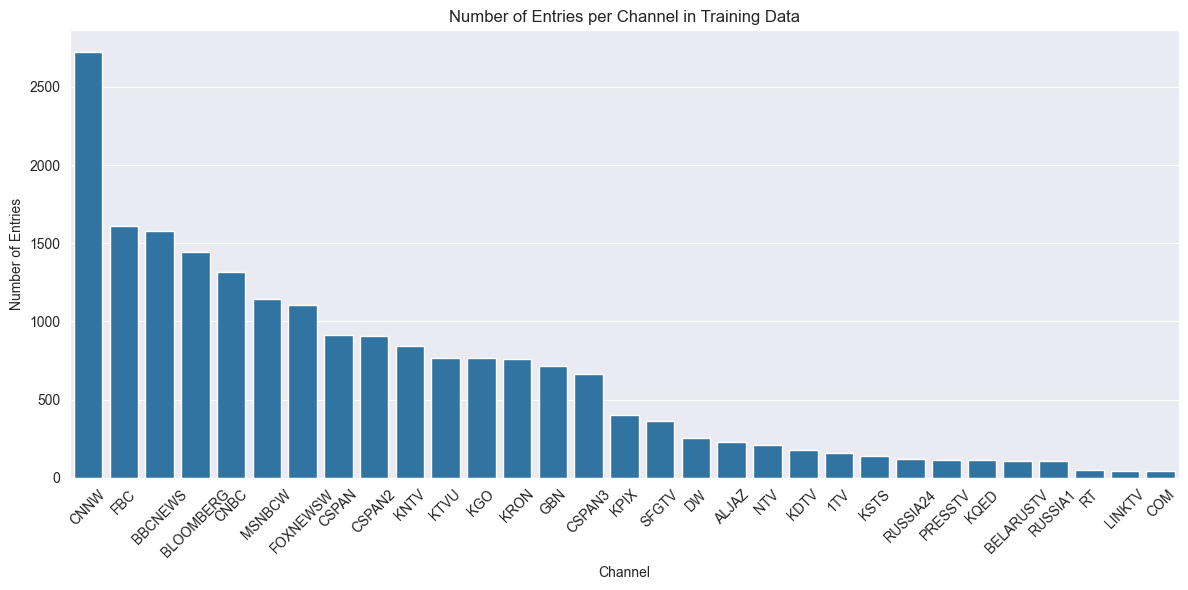

In [7]:
# Count the number of entries for each channel
channel_counts = train['channel'].value_counts()

# Set seaborn style
sns.set_style("darkgrid")

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Number of Entries per Channel in Training Data')
plt.xlabel('Channel')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()

### Part A: Feature Engineering and Baseline Models
#### Vanilla Model (no modifications to training data distributions)

In [9]:
# Helper function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_val, y_val, le, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print(f"=== {model_name} ===")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

    # Evaluate across all possible classes, even if some are missing in val set
    print("\nPer-Class Report (Validation):")
    print(classification_report(
        y_val,
        y_val_pred,
        labels=range(len(le.classes_)),
        target_names=le.classes_,
        zero_division=0  # Avoid divide-by-zero warnings for empty classes
    ))
    print("=" * 50)

# Main function to run models
def run_models(train, val, resampling=False):
    # Encode the labels
    # Convert channel names (strings) into numerical labels using LabelEncoder()
    le = LabelEncoder()
    y_train = le.fit_transform(train['channel'])  # Fit on training labels
    y_val = le.transform(val['channel']) 
    # Feature extraction using CountVectorizer
    # Convert text transcripts into a sparse matrix of token counts

    count_vec = CountVectorizer(max_features=10000)  # Limit vocabulary size to 10,000 for performance

    X_train_count = count_vec.fit_transform(train['snip'])  # Fit + transform on training transcripts
    X_val_count = count_vec.transform(val['snip'])          # Only transform on validation transcripts
    lr_count = LogisticRegression(max_iter=1000)
    if resampling is False:
        # Train and evaluate Logistic Regression on CountVectorizer features
        evaluate_model(lr_count, X_train_count, y_train, X_val_count, y_val, le, "Logistic Regression (CountVectorizer)")
    
    else:
        # Apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train_count, y_train)
        evaluate_model(lr_count, X_resampled, y_resampled, X_val_count, y_val, le, "Logistic Regression (CountVectorizer)")


    # Feature extraction using TfidfVectorizer
    # Convert text transcripts into TF-IDF-weighted features
    tfidf_vec = TfidfVectorizer(max_features=10000)  # Also limit vocabulary size here
    X_train_tfidf = tfidf_vec.fit_transform(train['snip'])  # Fit + transform on training transcripts
    X_val_tfidf = tfidf_vec.transform(val['snip'])          # Only transform on validation transcripts

    # Train and evaluate Logistic Regression on TF-IDF features
    lr_tfidf = LogisticRegression(max_iter=1000)  # Same model, different feature representation
    

    if resampling is False:
        evaluate_model(lr_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, le, "Logistic Regression (TFIDF)")
    else:
        X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
        evaluate_model(lr_tfidf, X_resampled, y_resampled, X_val_tfidf, y_val, le, "Logistic Regression (TFIDF)")
    return y_train

run_models(train, val)


=== Logistic Regression (CountVectorizer) ===
Train Accuracy: 0.9851054194132743
Validation Accuracy: 0.5205659756498848

Per-Class Report (Validation):
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.43      0.21      0.28        29
     BBCNEWS       0.67      0.62      0.64       271
   BELARUSTV       0.00      0.00      0.00         0
   BLOOMBERG       0.69      0.84      0.76       170
        CNBC       0.68      0.70      0.69       256
        CNNW       0.42      0.54      0.48       219
         COM       0.00      0.00      0.00         0
       CSPAN       0.43      0.48      0.45       204
      CSPAN2       0.26      0.43      0.32       165
      CSPAN3       0.31      0.15      0.20       177
          DW       0.62      0.46      0.53        46
         FBC       0.64      0.70      0.67       214
    FOXNEWSW       0.58      0.49      0.53       250
         GBN       0.22      0.79   

array([13,  8,  9, ..., 22,  9,  9], shape=(19873,))

The overall objective of this model is to classify cable news clips by predicting which channel (e.g., CNN, FOX, MSNBC, etc.) a given transcript snippet came from. To achieve this, the model uses logistic regression, a linear classification algorithm that learns to associate input features with probability scores for each possible class. In this context, the input features are generated from the raw transcript text using two common text vectorization methods: CountVectorizer, which represents each clip as a vector of word counts, and TfidfVectorizer, which scales word counts by their importance across documents. The logistic regression model is trained by minimizing a loss function (cross-entropy) that penalizes incorrect class predictions, adjusting model weights using gradient descent to improve prediction accuracy on the training data. Once trained, the model outputs a probability distribution over the possible classes for each input and selects the most likely one as its prediction. The evaluation focuses on measuring how well the model generalizes to unseen data (the validation set), using both overall accuracy and detailed per-class metrics to understand performance. The ultimate goal is to build a model that can accurately and reliably classify unseen transcript snippets into the correct news channel based solely on their textual content.

Overall Accuracy
Logistic Regression (CountVectorizer)

Train Accuracy: 98.5%
Validation Accuracy: 51.7%
Logistic Regression (TF-IDF)
Train Accuracy: 84.2%
Validation Accuracy: 54.1%

The CountVectorizer model achieved high training accuracy but significantly lower validation accuracy, indicating overfitting. In contrast, the TF-IDF model had a better train-validation balance and slightly improved validation performance, suggesting better generalization.

Per-Class Observations
Strong performing classes included:
BLOOMBERG, CNBC, KSTS, FOXNEWSW, and KDTV.
These had relatively high precision and recall, likely due to distinctive vocabulary or content.

Moderate performance was observed for mainstream channels such as:
BBCNEWS, CNNW, MSNBCW, and FBC.
These may share overlapping topics, making them harder to distinguish.

Poorly performing or misclassified classes included:
GBN, KQED, KPIX, DW, and RT, where the model struggled to make accurate predictions.

Some channels like 1TV, BELARUSTV, LINKTV, and RUSSIA1 had no support in the validation set, meaning they did not appear and could not be evaluated.

#### Linear Model with Class-Balancing Approaches

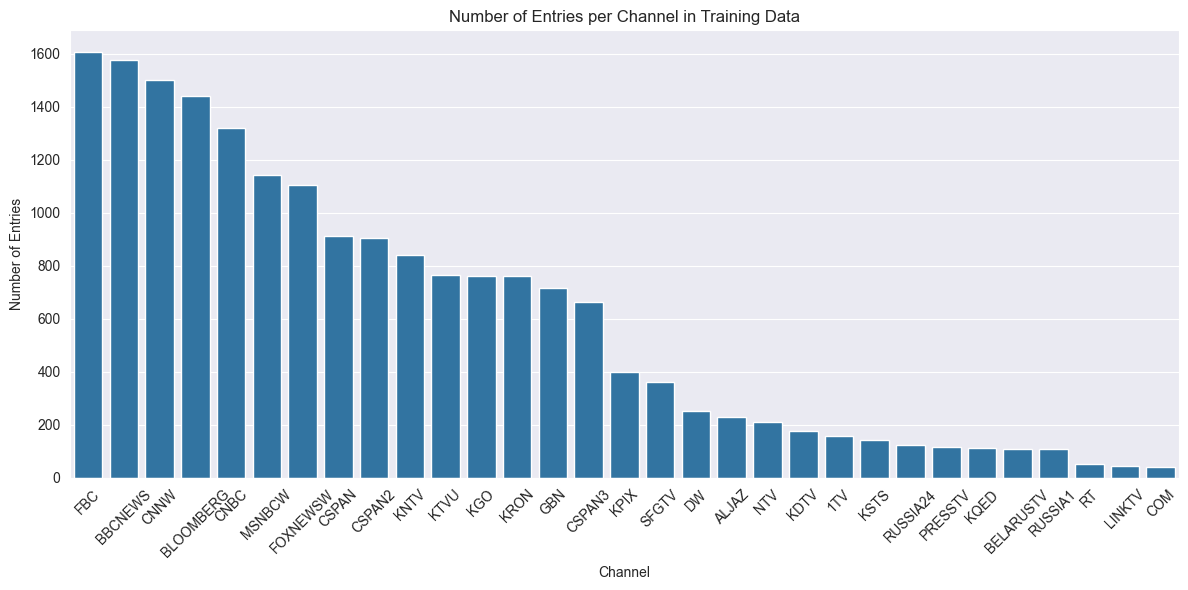

In [11]:
# Approach 1:Subsample the majority class
# Get indices of CNNW samples
cnnw_indices = train[train['channel'] == 'CNNW'].index
# Randomly select 1500 CNNW samples
selected_cnnw = np.random.choice(cnnw_indices, size=1500, replace=False)
# Get all non-CNNW samples
other_indices = train[train['channel'] != 'CNNW'].index
# Combine the selected CNNW samples with all other samples
selected_indices = np.concatenate([selected_cnnw, other_indices])
# Create new subsampled training set
undersampled_train = train.loc[selected_indices]

# Display the new class distribution
# Create the bar chart
channel_counts = undersampled_train['channel'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Number of Entries per Channel in Training Data')
plt.xlabel('Channel')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()

In [12]:
# Approach 1: Subsample the majority class
run_models(undersampled_train, val)

=== Logistic Regression (CountVectorizer) ===
Train Accuracy: 0.9843414843414844
Validation Accuracy: 0.5248436985850609

Per-Class Report (Validation):
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.43      0.21      0.28        29
     BBCNEWS       0.66      0.64      0.65       271
   BELARUSTV       0.00      0.00      0.00         0
   BLOOMBERG       0.69      0.85      0.76       170
        CNBC       0.63      0.69      0.66       256
        CNNW       0.53      0.50      0.52       219
         COM       0.00      0.00      0.00         0
       CSPAN       0.41      0.47      0.44       204
      CSPAN2       0.25      0.42      0.32       165
      CSPAN3       0.33      0.18      0.23       177
          DW       0.61      0.48      0.54        46
         FBC       0.63      0.69      0.66       214
    FOXNEWSW       0.59      0.53      0.56       250
         GBN       0.21      0.79   

array([ 6,  6,  6, ..., 22,  9,  9], shape=(18648,))

In [13]:
# Approach 2: SMOTE Oversampling
y_train = run_models(train, val, resampling=True)

=== Logistic Regression (CountVectorizer) ===
Train Accuracy: 0.9864456939923054
Validation Accuracy: 0.49029285949325435

Per-Class Report (Validation):
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.18      0.07      0.10        29
     BBCNEWS       0.62      0.60      0.61       271
   BELARUSTV       0.00      0.00      0.00         0
   BLOOMBERG       0.64      0.81      0.71       170
        CNBC       0.66      0.60      0.63       256
        CNNW       0.45      0.50      0.47       219
         COM       0.00      0.00      0.00         0
       CSPAN       0.42      0.50      0.46       204
      CSPAN2       0.25      0.33      0.28       165
      CSPAN3       0.29      0.15      0.19       177
          DW       0.53      0.50      0.52        46
         FBC       0.59      0.68      0.63       214
    FOXNEWSW       0.55      0.42      0.48       250
         GBN       0.22      0.79  

KeyboardInterrupt: 

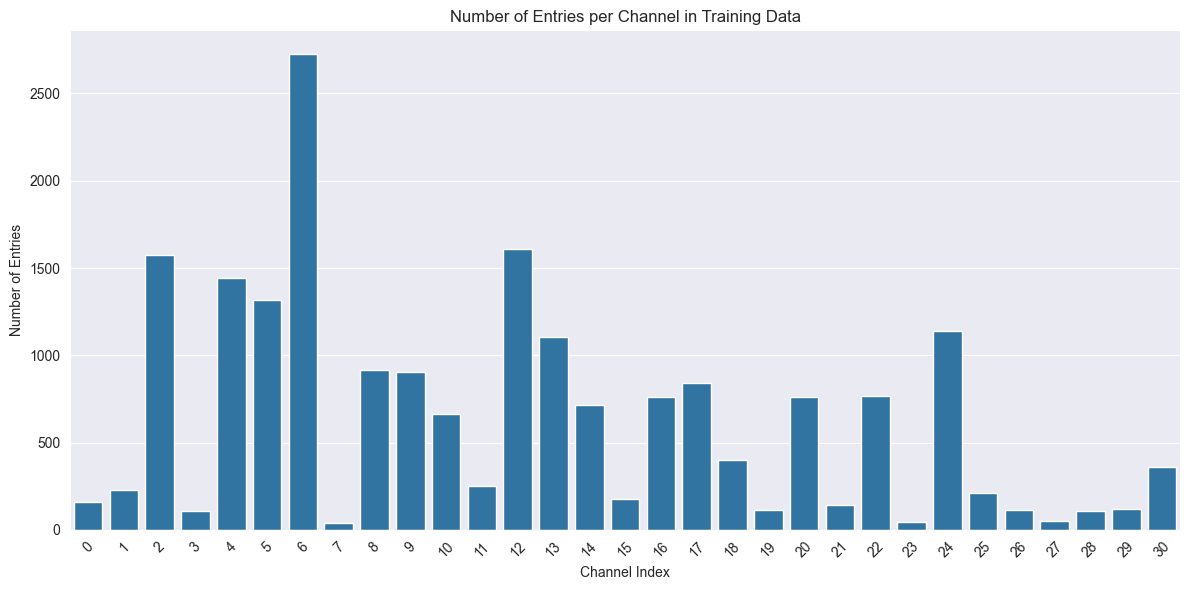

In [ ]:
# Display the new class distribution
# Create the bar chart
unique_values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_values, y=counts)
plt.title('Number of Entries per Channel in Training Data')
plt.xlabel('Channel Index')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# Helper function for cleaning text
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean